In [ ]:
from google.colab import drive

drive.mount('/gdrive')
!ls '/gdrive/My Drive/cse6242_project/Data'
!unzip -q '/gdrive/My Drive/cse6242_project/Data/celeba'

Mounted at /gdrive
accuracy_vs_num_images_18k.csv	celeba.zip
celeba_beit_index.ann		celeb_jpeg
celeba_vit_finetuned_index.ann	identity_CelebA.txt


In [ ]:
!pip install timm annoy

     |████████████████████████████████| 431 kB 5.0 MB/s 
     |████████████████████████████████| 646 kB 50.9 MB/s 
  Created wheel for annoy: filename=annoy-1.17.0-cp37-cp37m-linux_x86_64.whl size=391682 sha256=7b356706af6259daf7fa94ca3ae4f642aeb9cb7f8189c8a9953c054e1388d6cc
  Stored in directory: /root/.cache/pip/wheels/4f/e8/1e/7cc9ebbfa87a3b9f8ba79408d4d31831d67eea918b679a4c07
Successfully built annoy


In [ ]:
import pandas as pd
import numpy as np
import torchvision
import requests
import random
import torch
from torch import nn
from torchvision import transforms
from PIL import Image
from annoy import AnnoyIndex
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from collections import defaultdict

np.random.seed(42)

In [ ]:
# read pre-built index
def get_annoy_index(df, index_file, dim=768, metric='euclidean'):
    print(f'loading {index_file}...')
    idx_to_identity = df.to_dict('index')
    identity_to_idx = defaultdict(list) 
    index = AnnoyIndex(dim, metric)
    index.load(index_file)

    images, keys = [], []
    for k, v in idx_to_identity.items():
      identity_to_idx[v["identity"]].append(k)
      keys.append(k)

    return index, idx_to_identity, identity_to_idx

# create identities
def get_identities(n_identities=1000):
    print('loading data...')
    identities = pd.read_csv("/gdrive/My Drive/cse6242_project/Data/identity_CelebA.txt", sep=" ", header=None)
    identities.rename(columns={0: "file", 1: "identity"}, inplace=True) 
    identity_selection = identities.identity.unique()
    df = identities[identities.identity.isin(identity_selection)].reset_index()
    identity_selection = np.random.choice(identities.identity.unique(), n_identities)
    return df, identity_selection

def retrival_accuracy(base_idx, image_idx, idx_to_identity, identity_to_idx):
    true_identity = idx_to_identity[base_idx]["identity"]
    n_true_matches = len(identity_to_idx[true_identity])

    hits = []

    for idx in image_idx:
        idx_identity = idx_to_identity[idx]["identity"]

        if idx_identity == true_identity:
            hits.append(True)
        else:
            hits.append(False)

    return sum(hits) / min(len(image_idx), n_true_matches)


In [ ]:
df, identity_selection = get_identities()
results = defaultdict(list)
for index_file in ['celeba_vit_finetuned_index.ann', 'celeba_beit_index.ann']:
  index, idx_to_identity, identity_to_idx = get_annoy_index(
      df, index_file=f'/gdrive/My Drive/cse6242_project/Data/{index_file}')

  test_accuracies = []
  for identity in tqdm(identity_selection):
    base_image_idx = random.choice(identity_to_idx[identity])
    close_image_idx = index.get_nns_by_item(base_image_idx, 3, search_k=-1, include_distances=False)
    test_accuracies.append(retrival_accuracy(base_image_idx, close_image_idx, idx_to_identity, identity_to_idx))
    acc = np.mean(test_accuracies)
    results[index_file].append(acc)

pd.DataFrame(results).plot(figsize=(20, 10), title='retrieval accuracy vs annoy index')

NameError: ignored

In [ ]:
results

defaultdict(list,
            {'celeba_beit_index.ann': [{0.2},
              {0.2},
              {0.3333333333333333},
              {0.3},
              {0.32},
              {0.3},
              {0.31428571428571433},
              {0.30000000000000004},
              {0.288888888888889},
              {0.32000000000000006},
              {0.30909090909090914},
              {0.3000000000000001},
              {0.30769230769230776},
              {0.3000000000000001},
              {0.3022222222222223},
              {0.30833333333333335},
              {0.3019607843137255},
              {0.29629629629629634},
              {0.2912280701754386},
              {0.3066666666666667},
              {0.3015873015873016},
              {0.296969696969697},
              {0.29275362318840586},
              {0.2888888888888889},
              {0.2853333333333333},
              {0.28205128205128205},
              {0.2790123456790124},
              {0.2761904761904762},
              {0

loading data...
loading annoy index...


100%|██████████| 10177/10177 [00:24<00:00, 410.15it/s]


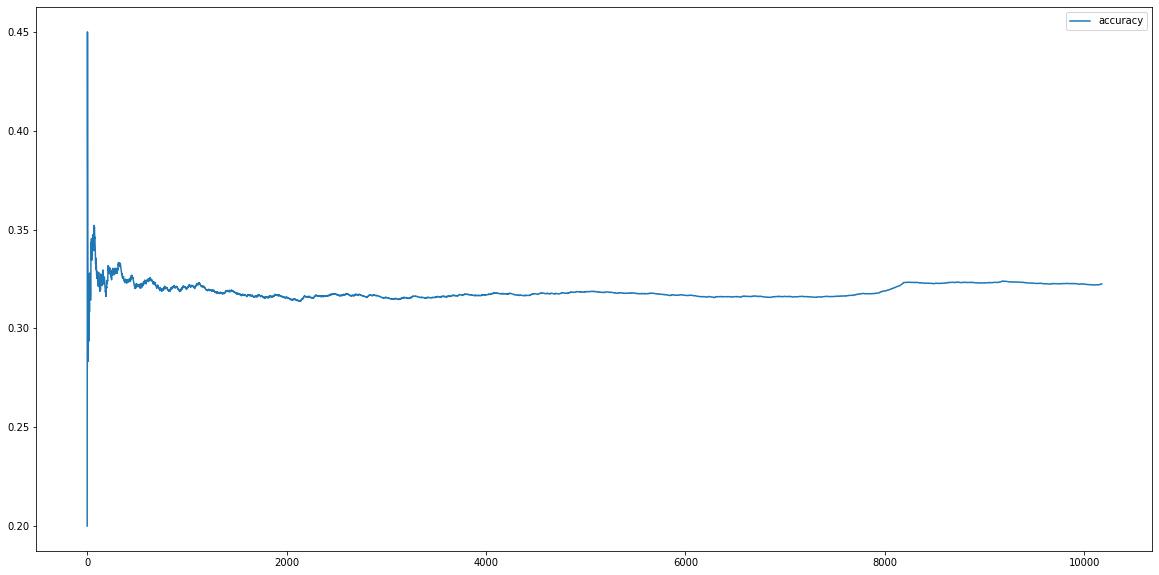

In [ ]:
df, identity_selection = get_identities()
index, idx_to_identity, identity_to_idx = get_annoy_index(
    df, index_file='/gdrive/My Drive/cse6242_project/Data/celeba_beit_index.ann')

test_accuracies = []
results = []
for identity in tqdm(identity_selection):
  base_image_idx = random.choice(identity_to_idx[identity])
  close_image_idx = index.get_nns_by_item(base_image_idx, 5, search_k=-1, include_distances=False)
  test_accuracies.append(retrival_accuracy(base_image_idx, close_image_idx, idx_to_identity, identity_to_idx))
  acc = np.mean(test_accuracies)
  results.append({'accuracy': acc})

pd.DataFrame(results).plot(figsize=(20, 10))